<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/MACHINE%20LEARNING%20Y%20DEEP%20LEARNING/6_TransferLearningMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Transfer Learning en MLPs**

- Generalmente no es una buena idea entrenar un DNN muy grande desde cero sin intentar primero encontrar una red neuronal existente que consiga resolver un tarea similar a la que se está tratando de abordar.

- Si encuentra una red neuronal, entonces se puede
reutilizar la mayoría de sus capas, excepto las últimas. Esta técnica se denomina Transfer Learning.

- No sólo acelerará considerablemente el entrenamiento, sino que también requiere menos datos para entrenar.

- Suponga que se tiene acceso a un DNN que fue entrenada para clasificar imágenes en 100 categorías diferentes, incluidos animales, plantas, vehículos, etc. y ahora desea entrenar un DNN para clasificar tipos específicos de
vehículos. Estas tareas son muy similares, incluso parcialmente superpuestas, por lo que se debería intentar reutilizar partes de la primera red.

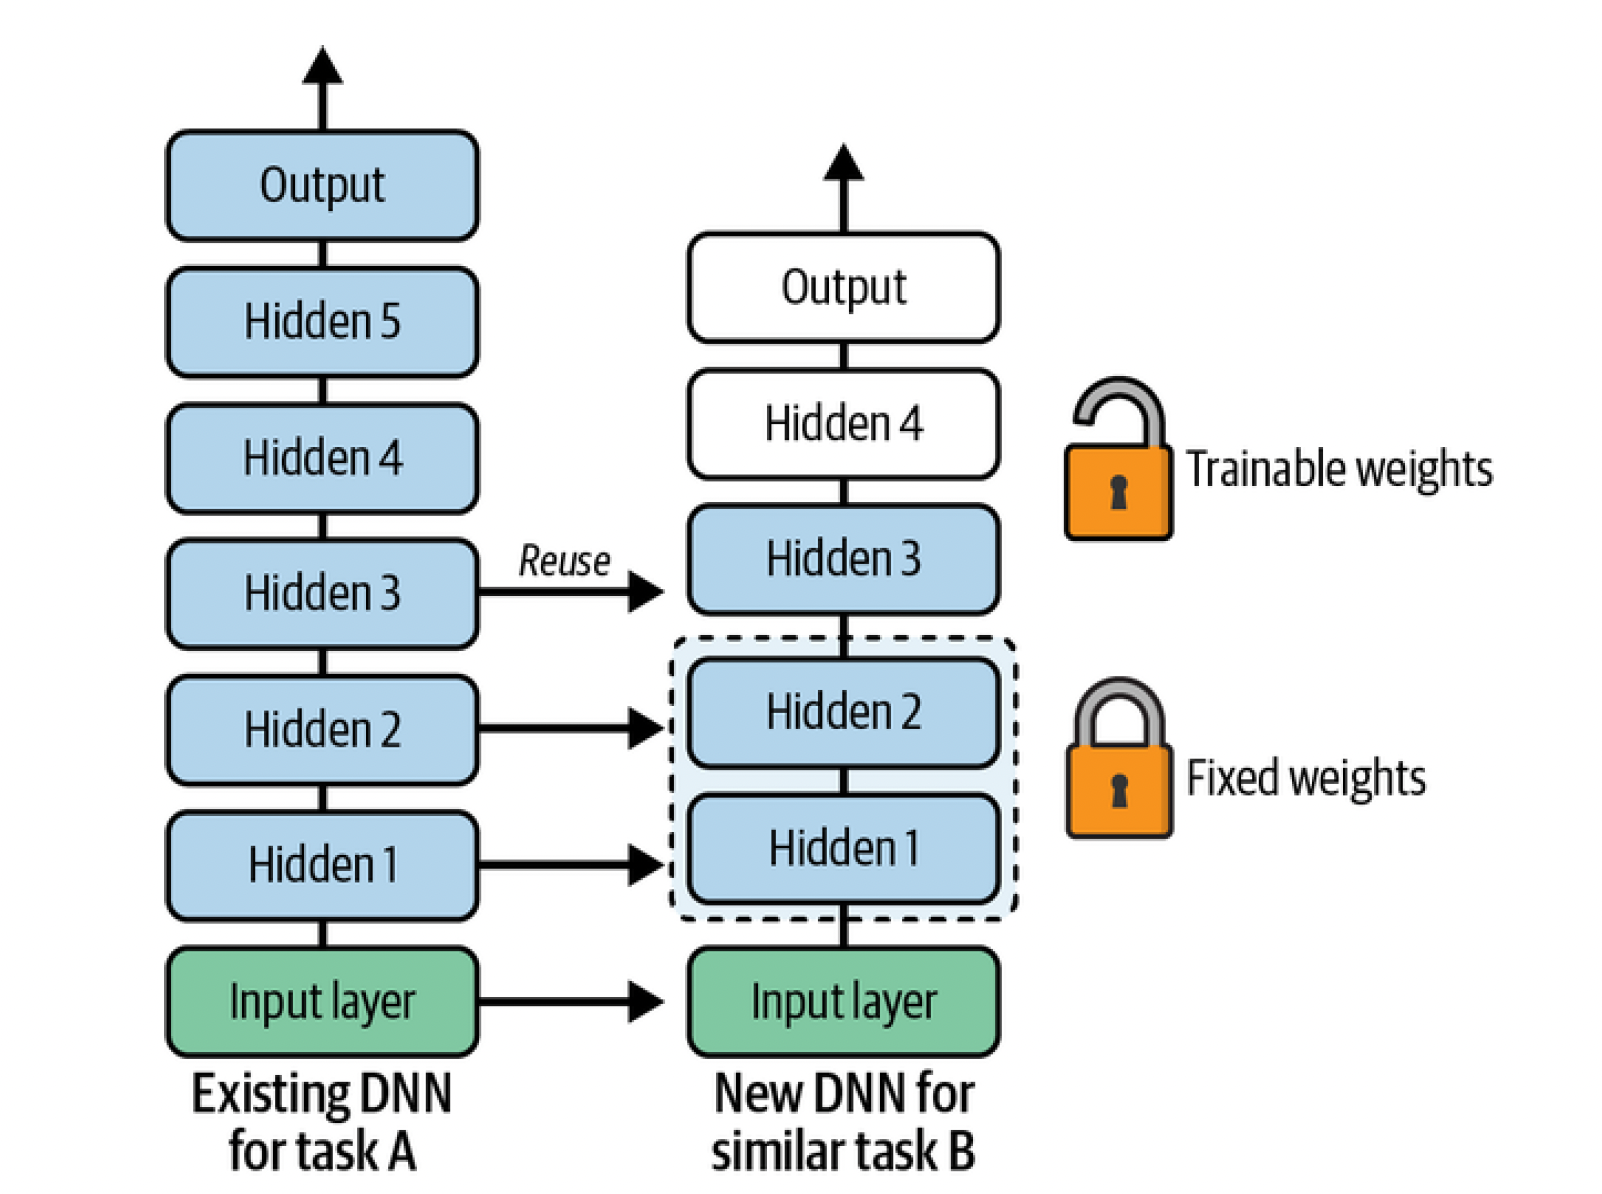

- La capa de salida del modelo original normalmente debe reemplazarse porque lo más probable es que no sea útil para la nueva tarea y no tenga el número correcto de salidas.
- De manera similar, es poco probable que las capas superiores ocultas del modelo original sean útiles ya que las características de alto nivel, que son más
útiles para la nueva tarea, pueden diferir significativamente de las que fueron útiles para la tarea original. Se quiere encontrar el número correcto de
capas para reutilizar.

- Intente congelar primero todas las capas reutilizadas (es decir, haga que sus pesos no se puedan entrenar)
para que gradiente descendiente no los modifique y permanezcan fijos),
- Luego entrene su modelo y vea cómo funciona.
- Luego intente descongelar una o dos de las capas ocultas superiores para permitir que backpropagation las modifique y vea si el rendimiento mejora.

- Cuantos más datos de entrenamiento se tenga, más capas se puede ir  descongelando.

- También es útil reducir la tasa de aprendizaje cuando se descongelen las capas reutilizadas: esto evitará arruinar sus pesos afinados.

- Si aún no se consigue un buen rendimiento, y se tiene pocos datos de entrenamiento, intente eliminar las capas ocultas superiores y congelar todas las capas ocultas restantes. Puede iterar hasta encontrar el número correcto de capas para reutilizar.

- Si se tiene muchos datos de entrenamiento, se puede intentar reemplazar las capas ocultas superiores en lugar de eliminarlas, e incluso agregar más capas ocultas.

In [ ]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import numpy as np

Datos: Fashion MNIST

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

##**Transfer Learning con Keras**

Dividamos el conjunto de entrenamiento MNIST de moda en dos:

- ``X_train_A``: imágenes de todos los artículos excepto camisetas/tops y jerseys (clases 0 y 2).
- ``X_train_B``: un conjunto de entrenamiento mucho más pequeño de solo las primeras 200 imágenes de camisetas/tops y jerseys.

El conjunto de validación y el conjunto de prueba también se dividen de esta manera, pero sin restringir el número de imágenes.

Proceso:

- Se entrenará un modelo para el conjunto A (tarea de clasificación con 8 clases) y se intentará reutilizarlo para abordar el conjunto B (clasificación binaria).

- Se espera transferir un poco de conocimiento de la tarea A a la tarea B, ya que las clases del conjunto A (pantalones, vestidos, abrigos, sandalias, camisas, zapatillas, bolsos y botines) son algo similares a las clases del conjunto B (camisas/tops y jerseys).

- Dado que se utilizan capas densas, solo se pueden reutilizar los patrones que ocurren en la misma ubicación (por el contrario, las capas convolucionales se transferirán mucho mejor, ya que los patrones aprendidos se pueden detectar en cualquier parte de la imagen).

In [ ]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 10s 6ms/step - loss: 1.1683 - accuracy: 0.6312 - val_loss: 0.7052 - val_accuracy: 0.7739
Epoch 2/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.6069 - accuracy: 0.8042 - val_loss: 0.5083 - val_accuracy: 0.8373
Epoch 3/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4819 - accuracy: 0.8456 - val_loss: 0.4333 - val_accuracy: 0.8604
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4221 - accuracy: 0.8601 - val_loss: 0.3910 - val_accuracy: 0.8669
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3859 - accuracy: 0.8705 - val_loss: 0.3650 - val_accuracy: 0.8742
Epoch 6/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3611 - accuracy: 0.8773 - val_loss: 0.3461 - val_accuracy: 0.8817
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3434 - accuracy: 0.8823 - val_loss: 0.3328 - val_accuracy

Entrenamiento del Modelo B sin usar A

In [ ]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 2s 89ms/step - loss: 0.7001 - accuracy: 0.5200 - val_loss: 0.6915 - val_accuracy: 0.5519
Epoch 2/20
7/7 [==============================] - 0s 22ms/step - loss: 0.6773 - accuracy: 0.5850 - val_loss: 0.6728 - val_accuracy: 0.6241
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6584 - accuracy: 0.6950 - val_loss: 0.6573 - val_accuracy: 0.6647
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6418 - accuracy: 0.7500 - val_loss: 0.6434 - val_accuracy: 0.7033
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6279 - accuracy: 0.8000 - val_loss: 0.6290 - val_accuracy: 0.7458
Epoch 6/20
7/7 [==============================] - 0s 31ms/step - loss: 0.6137 - accuracy: 0.8300 - val_loss: 0.6162 - val_accuracy: 0.7774
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6005 - accuracy: 0.8450 - val_loss: 0.6036 - val_accuracy: 0.8190
Epoch 8/20
7/7 [===========

[0.49023789167404175, 0.9169999957084656]

El Modelo B alcanza un accuracy del 91,69% en el conjunto de prueba. Ahora intentemos reutilizar el modelo A previamente entrenado.

In [ ]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Tenga en cuenta que model_A y model_B_on_A ahora comparten algunas capas. Si se entrena model_B_on_A, también afectará a model_A. Para evitar esto se debe clonar model_A antes de reutilizar sus capas. Para esto, se clona la arquitectura del modelo A con ``clone_model()``
, y luego se copia sus pesos.

Nota: ``tf.keras.models.clone_model()`` solo clona la arquitectura, no los
pesos. Si no se copia manualmente usando set_weights(), serán
inicializados aleatoriamente al utilizar por primera vez el modelo clonado.

In [ ]:
tf.random.set_seed(42)  # extra code – ensure reproducibility
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_A_clone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_B_on_A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Ahora se puede entrenar el model_B_on_A para la tarea B, pero dado que la capa de salida se inicializó aleatoriamente cometerá grandes errores (al menos durante las primeras épocas), por lo que habrá errores de gradientes grandes que pueden arruinar los pesos reutilizados.

- Para evitar esto, una solución es congelar las capas reutilizadas durante las primeras épocas, dándole a la nueva capa algo de tiempo para aprender pesos razonables.

- Para hacer esto, defina el atributo ``trainable`` de cada capa en Falso y compile el modelo:

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Nota: siempre se debe compilar el modelo después de congelar o descongelar capas.

- Ahora  se puede entrenar el modelo durante algunas épocas y luego descongelar las capas del modelo reutilizado (lo que requiere compilar el modelo nuevamente) y continuar entrenando para afinar las capas reutilizadas para la tarea B.

- Después de descongelar las capas reutilizadas, es una buena idea reducir la tasa de aprendizaje, para evitar dañar las pesoss reutilizados.

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# descongela capas
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 49ms/step - loss: 0.8913 - accuracy: 0.4000 - val_loss: 0.8059 - val_accuracy: 0.4095
Epoch 2/4
7/7 [==============================] - 0s 18ms/step - loss: 0.8187 - accuracy: 0.3650 - val_loss: 0.7852 - val_accuracy: 0.3887
Epoch 3/4
7/7 [==============================] - 0s 20ms/step - loss: 0.7992 - accuracy: 0.3750 - val_loss: 0.7812 - val_accuracy: 0.4164
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.7774 - accuracy: 0.3750 - val_loss: 0.7645 - val_accuracy: 0.4293
Epoch 1/16
7/7 [==============================] - 1s 49ms/step - loss: 0.7405 - accuracy: 0.4500 - val_loss: 0.6889 - val_accuracy: 0.5163
Epoch 2/16
7/7 [==============================] - 0s 17ms/step - loss: 0.6766 - accuracy: 0.5600 - val_loss: 0.6303 - val_accuracy: 0.6439
Epoch 3/16
7/7 [==============================] - 0s 31ms/step - loss: 0.6233 - accuracy: 0.6800 - val_loss: 0.5994 - val_accuracy: 0.7319
Epoch 4/16
7/7 [===============

Entonces, ¿cuál es el veredicto final? Bueno, la precisión de la prueba de este modelo es del 93,85%, un aumento
¡Exactamente dos puntos porcentuales del 91,85%! Esto significa que la transferencia
El aprendizaje redujo la tasa de error en casi un 25%:

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.3296 - accuracy: 0.9170


[0.3296382427215576, 0.9169999957084656]

- El resultado no es muy significativo.
- Transfer Learning no funciona muy bien con redes pequeñas y densas, presumiblemente porque las redes pequeñas aprenden pocos patrones y las redes densas aprenden patrones muy específicos, que no será útiles en otras tareas.
- Transfer Learning funciona mejor con
redes neuronales convolucionales, que tienden a aprender detectores de características que son
mucho más generales (especialmente en las capas inferiores)

**Preentrenamiento no supervisado**

- Suponga que desea abordar una tarea compleja para la cual no se tiene datos de entrenamiento etiquetados, y tampoco  puede encontrar un modelo entrenado en un
tarea similar.
- Una opción es usar pre entrenamiento no supervisado: si se puede reunir suficientes datos de entrenamiento sin etiquetar, se puede intentar usarlos para entrenar un modelo no supervisado *autoencoder*  o una *generative adversarial network* (GAN).

- Luego se puede reutilizar las capas inferiores del autoencoder o del discriminador de la GAN, agregar la capa de salida para su tarea específica y ajustar la red final mediante aprendizaje supervisado (es decir, con los pocos ejemplos de entrenamiento etiquetados que tenga).


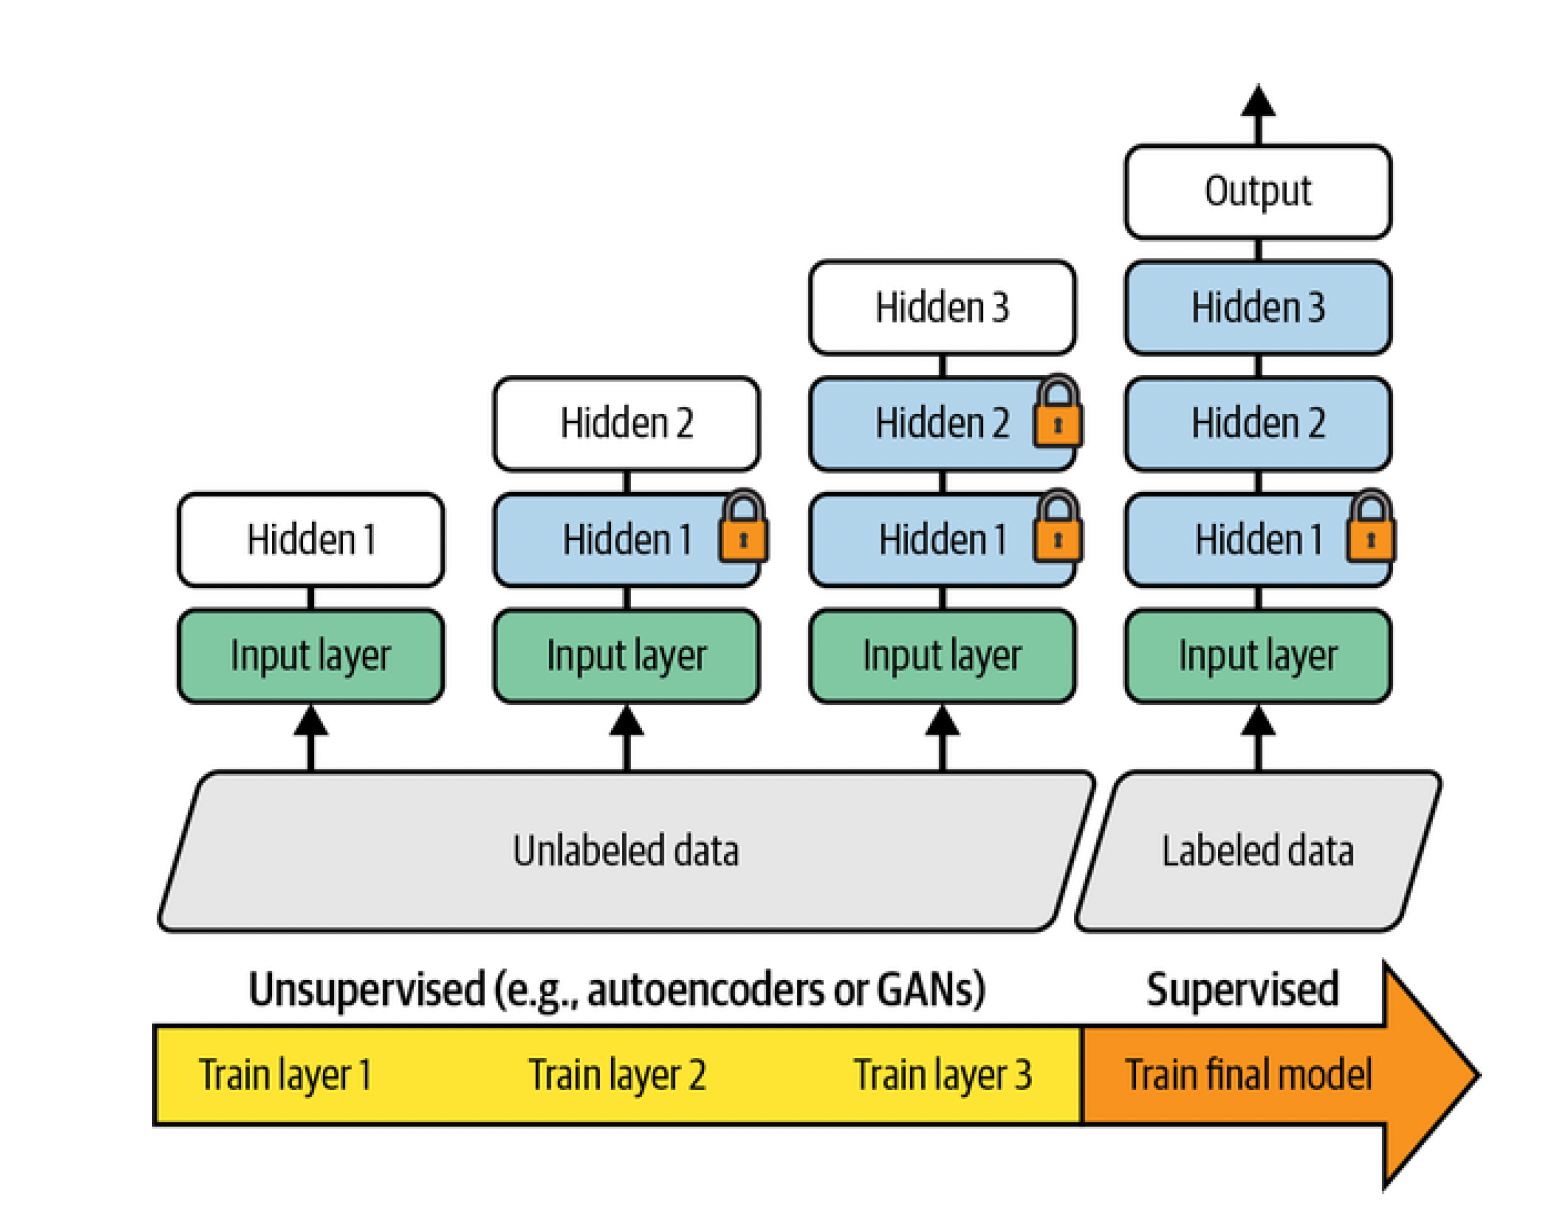


- Es esta técnica la que Geoffrey Hinton y su equipo utilizaron en 2006, y lo que condujo al resurgimiento de las redes neuronales y el nacimiento del Deep Learning

- Hasta el 2010, el preentrenamiento no supervisado (normalmente con máquinas Boltzmann restringidas (RBM; https://homl.info/extraanns)) era lo usual para las redes profundas.

-  Sólo después de que el problema de los Vanishing gradients se alivió se volvió mucho más común entrenar DNN utilizando puramente el aprendizaje supervisado.

- El entrenamiento previo no supervisado (hoy en día típicamente usando autoencoders o GANs en lugar de RBMs) sigue siendo una buena opción cuando se tienes una tarea compleja, ningún modelo similar para reutilizar, pocos
datos de entrenamiento etiquetados pero muchos datos de entrenamiento sin etiquetar.

En los primeros días del aprendizaje profundo era difícil entrenar modelos, por lo que la gente usaba una técnica llamada *greedy layer-wise
pretraining* (representado en la Figura).

- Primero se entrenaba un modelo no supervisado con una sola capa, típicamente un RBM,
- Entonces, se congelaba esa capa y se agregaba otra encima, y se entrenaba el modelo nuevamente (simplemente entrenando la nueva capa),

- Luego se congelaba la nueva capa y se agregaba otra capa encima, se entrenab el modelo nuevamente, y así sucesivamente.

Hoy en día, las cosas son mucho más simples: la gente generalmente entrena el modelo completo sin supervisión.
de una sola vez y se utiliza autoencoders o GANs en lugar de RBMs.

**Entrenamiento previo en una tarea auxiliar**

- Si no se tiene muchos datos de entrenamiento etiquetados, una última opción es entrenar una primera red neuronal en una tarea auxiliar para la cual puede obtener o
generar datos de entrenamiento etiquetados y luego reutilizar las capas inferiores de esa red
para su tarea real.

- Las capas inferiores de la primera red neuronal aprenderán
detectores de características que probablemente serán reutilizables por la segunda red neuronal.

- Por ejemplo, si desea crear un sistema para reconocer rostros, pueda que sólo tenga unas pocas fotografías de cada individuo, lo que claramente no es suficiente para entrenar un buen clasificador. Reunir cientos de fotografías de cada persona no sería práctico. Sin embargo, se puede reunir muchas fotografías de personas al azar en la web y entrenar una primera red neuronal para detectar si dos imágenes diferentes muestran a la misma persona.

- Una red así aprendería bien detectores de características para rostros, por lo que reutilizar sus capas inferiores le permitiría entrenar un buen clasificador facial que utilice pocos datos de entrenamiento.


- Para aplicaciones de procesamiento del lenguaje natural (NLP), se puede descargar un corpus de millones de documentos de texto y generar automáticamente etiquetas
del mismo.
- Por ejemplo, se podría enmascarar aleatoriamente algunas palabras y entrenar un modelo para predecir cuáles son las palabras que faltan (por ejemplo, debería predecir
que la palabra que falta en la oración "¿Qué ___ diciendo?" puede ser “estas” o “están”).

- Si se puede entrenar un modelo para alcanzar un buen rendimiento en esta tarea, entonces ya tendrá bastante información sobre el lenguaje y se podrá ciertamente reutilizarlo para su tarea real y aprender a partir de sus datos etiquetados.

Nota: *self supervised learning* es cuando generas automáticamente las etiquetas a partir de los datos, como en el ejemplo de enmascaramiento de texto, luego se entrena un modelo con el conjunto "etiquetado" resultante utilizando técnicas de aprendizaje supervisado.